In [ ]:
from IPython.display import display, HTML
display(HTML('<script>var my_section = document.querySelector("#my-section"); if (my_section) { my_section.scrollIntoView({behavior: "smooth"}); }</script>'))

v0.2 추가내용
섹션
- 데이터 정리해보기
[이동할 섹션](#데이터정리해보기)
- channel 데이터프레임을 리뉴얼해보자.(channel_df)로 만들었어요
[이동할 섹션](#channel데이터프레임을리뉴얼해보자)


## Data 설명(강사님께서 하신 말씀)

subsr : 사용자 고유 번호(셋탑 고유번호) <br>
use_tms : 시청 시간(초단위), 0이라면 들어오자마자 빠져나간 것, 제거 가능 <br>
strt_dt : 시청 시작 시간 <br>
동일한 컨텐츠가 여러 개 있는 경우 : 마케팅 목적에 따라 여러 개 등록될 수 있다? 뭔소리야 <br>
runningtime 109분인데 시청시간 200분으로 나오는 것 처럼 시청 시간이 긴 것은 중지 시간이 포함된 것 이다.
<br><br>
content 의 log_dt와 strt_dt는 동일한 의미를 갖는 컬럼이다. <br>
커머스와 channel_pgm에도 동일형태 컬럼 있는데, 이도 동일한 컬럼임 <br>
series_nm 컬럼이 컨텐츠의 시리즈를 나타낸다고 하는데, 비어있는 데이터가 존재하는 이유 - 오분류 데이터 <br>
영화에 series_nm이 있는 경우도 이는 오분류 데이터임 (제거) <br>
컨텐츠 이름에 ... 이 포함되는 경우는 입력을 그렇게 한 것입니다 <br>
자막과 자막 서비스는 동일한 의미입니다. <br>
비슷한 카테고리로 판단되는 것들은 하나로 묶어도 됩니다. <br>
<br><br>
channel_pgm 컬럼명은 제공할게용
콘텐츠 이름이 포함된 컬럼의 데이터를 제외하고 나머지 데이터가 전부 동일한 케이스는 데이터 생성 과정의 오류라서 하나를 삭제 <br>
채널의 시청 시간은 max 3시간이다. 즉, 이 이상이면 존재할 수 없는 데이터이다. <br>use_tms가 10800 이상이면 잘못된 데이터이다. <br>
<br><br>
데이터 업데이트 주기 - 계속 <br>
모델은 얼마만에 한 번 씩 생성하느냐의 문제이다.
프로그램에 대한 url은 제공을 할 예정....?
<br><br>
vod는 실제로 시청을 한 것이고, 컨텐츠는 상세보기 입니다.(들어온 것)
이렇다 보니, 컨텐츠에는 존재하는데 vod에는 존재하지 않는 고객이 존재합니다.
<br><br>
클릿 횟수나 노출 시간은 데이터가 존재하지 않습니다.<br>
결국 파생변수로 만들어야 합니다.
<br><br>
프로그램 정보가 있는 데이터는 제공이 가능합니다. <br>
기타로 구분된 장르는 판매사에서 기타로 넣은 것<br>
장르 - 우리동네, 헬로비전 자체 프로그램<br>
<br><br>
10월달 데이터를 추가로 받을 수 있을까? <br>
가능하다 !!! -> 하지만, 사유를 받아야 합니다.<br>
<br><br>
외부 데이터 사용?<br>
연령대별과 같이 대상을 나눠 추천시스템 제작이 가능하냐? 가능은 하다.<br>
다른 정보 제공 (가능) <br>
로그가 찍힌 시점은 로그 내에서 파악을 할 수 있지 <br>


<a id="데이터정리해보기"></a>
## 데이터 정리해보기

*   우리가 가지고 있는 데이터
  1. vod 시청 기록 데이터(vod)
  2. vod 상세보기 접근 데이터(content)
  3. channel 돌리면서 시청한 데이터(channel)
  4. (new)VOD 프로그램 정보 관련 데이터

*   우리가 만들어 볼 수 있는 데이터
  1. 기존 데이터프레임(vod, channel, content)의 컬럼명을 합치고, running_time 과 같이 파생변수를 만들 수 있는 데이터 추가하기
  2. 이후, running_time과 use_tms를 이욯하여 프로그램 관심 비율을 파생 변수로 생성하듯이 추가로 생성할 파생변수 확인하기
  3. 평가지표로 어떤 것을 사용할 수 있을 지 생각해 봅시다.
  4. 우선 데이터 자체는 받지 못했기 때문에, 데이터 받으면 전처리 작업을 하겠습니다.

## Import

In [ ]:
!pip install matplotlib -U
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install pytimekr

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family']=['NanumGothic','sans-serif']
plt.rcParams['axes.unicode_minus']=False
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib as mpl
import platform
import warnings
import datetime
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 5500
# from pytimekr import pytimekr
# pd.options.display.max_columns = 20

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#구글드라이브연동

Mounted at /content/drive


## Data Load

In [ ]:
content_8 = pd.read_csv('/content/drive/MyDrive/hv_project/5_Data/데이터스쿨3차_2308월/데이터스쿨_3차_콘텐츠_2308.csv',sep='\t', encoding='euc-kr')
content_9 = pd.read_csv('/content/drive/MyDrive/hv_project/5_Data/데이터스쿨3차_2309월/데이터스쿨_3차_콘텐츠_2309.csv', sep='\t', encoding='euc-kr')
vod_8 = pd.read_csv('/content/drive/MyDrive/hv_project/5_Data/데이터스쿨3차_2308월/데이터스쿨_3차_VOD_2308.csv', sep='\t', encoding='euc-kr')
vod_9 = pd.read_csv('/content/drive/MyDrive/hv_project/5_Data/데이터스쿨3차_2309월/데이터스쿨_3차_VOD_2309.csv',sep='\t', encoding='euc-kr')

In [ ]:
print('content', len(content_8))
print('vod', len(vod_8))

content 15677
vod 5615


In [ ]:
channel_8 = pd.read_csv('/content/drive/MyDrive/hv_project/5_Data/데이터스쿨3차_2308월/데이터스쿨3차_채널PGM_2308월.csv', sep=',', encoding='euc-kr', error_bad_lines=False)
channel_9 = pd.read_csv('/content/drive/MyDrive/hv_project/5_Data/데이터스쿨3차_2309월/데이터스쿨3차_채널PGM_2309월.csv',sep=',', encoding='euc-kr', error_bad_lines=False)

In [ ]:
content_8.head()

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt
0,65968000,(영어더빙)핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,0:01,20230813071155
1,65968000,(영어더빙)핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,0:01,20230813071215
2,66056000,라바 키즈동요(한국어) Part4,라바 키즈동요(한국어) Part4 17회,키즈,기타,징글벨 크리스마스. 안녕하신가 친구들! 메리 크리스마스~ 징글벨 크리스마스 징글벨 ...,"엘로우,레드",0:02,20230808085440
3,66056000,라바 키즈동요(한국어) Part4,라바 키즈동요(한국어) Part4 17회,키즈,기타,징글벨 크리스마스. 안녕하신가 친구들! 메리 크리스마스~ 징글벨 크리스마스 징글벨 ...,"엘로우,레드",0:02,20230808085432
4,63086000,지니강이 플러스 시즌7.,지니강이 플러스 시즌7. 26회,키즈,기타,로봇 세상에서 킥보드를 타요. 로보카 폴리 브룸스 타운에서 킥보드를 타요~ / 새로...,"헤이지니,럭키강이",0:11,20230827145542


In [ ]:
vod_8.head()

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,strt_dt
0,65941000,(HD)그것이알고싶다 1361회(23/07/22),TV 시사/교양,기타,4800,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,1:20,20230812163507
1,66873000,(HD)그것이알고싶다 1361회(23/07/22),TV 시사/교양,기타,4800,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,1:20,20230816205227
2,66873000,(HD)그것이알고싶다 1361회(23/07/22),TV 시사/교양,기타,718,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,1:20,20230829194727
3,61689000,(HD)그것이알고싶다 1361회(23/07/22),TV 시사/교양,기타,4800,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,1:20,20230813130609
4,61619000,꼬리에꼬리를무는그날이야기 37회(22/07/21),TV 시사/교양,기타,4183,"살인범의 미토콘드리아 - 2006 냉동고 살인사건. 2006년 7월 23일, 서울 ...","장도연,장현성,장성규",1:13,20230804092737


In [ ]:
channel_8.head()

,subsr,chnl_nm,in_dt,use_tms,pgm_nm,summary,cast,program_duration_minutes
0,61236000,아시아 M,20230801234657,2219,유감스러운 도시,NaN,"정웅인,정준호,정운택",70.0
1,65999000,아시아 M,20230801231758,7,유감스러운 도시,NaN,"정웅인,정준호,정운택",70.0
2,65532000,아시아 M,20230801235426,9,유감스러운 도시,NaN,"정웅인,정준호,정운택",70.0
3,66035000,아시아 M,20230801223927,1943,유감스러운 도시,NaN,"정웅인,정준호,정운택",70.0
4,65999000,아시아 M,20230801231750,6,유감스러운 도시,NaN,"정웅인,정준호,정운택",70.0


## 전처리 작업

### 각 데이터프레임 컬럼 정리좀 하기

vod 컬럼 러닝타임 (초) 만들고, 시간대비 시청시간비율 파생변수 생성

In [ ]:
def convert_to_seconds(time_str):
    try:
        hours, minutes, seconds = map(int, time_str.split(':'))
        return hours * 3600 + minutes * 60 + seconds
    except ValueError:
        return 0

vod_9['strt_dt'] = vod_9['strt_dt'].astype(str).replace('nan', '00:00:00')
vod_9['running_time'] = vod_9['strt_dt'].apply(convert_to_seconds)
vod_9['watching_ratio'] = round((vod_9['use_tms'] / vod_9['running_time']) * 100, 2)

In [ ]:
vod_9.head()

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,strt_dt,running_time,watching_ratio
0,60939000,(자막)아바타: 물의 길,영화,SF/환타지,4386,첫 번째 영화 아바타 이후 10년 이상 지난 때를 배경으로 하는 아바타: 물의 길은...,"샘 워싱턴,조 샐다나,시고니 위버,스티븐 랭,케이트 윈슬렛",03:12:00,11520,38.07
1,60939000,(자막)아바타: 물의 길,영화,SF/환타지,978,첫 번째 영화 아바타 이후 10년 이상 지난 때를 배경으로 하는 아바타: 물의 길은...,"샘 워싱턴,조 샐다나,시고니 위버,스티븐 랭,케이트 윈슬렛",03:12:00,11520,8.49
2,60939000,(자막)아바타: 물의 길,영화,SF/환타지,1837,첫 번째 영화 아바타 이후 10년 이상 지난 때를 배경으로 하는 아바타: 물의 길은...,"샘 워싱턴,조 샐다나,시고니 위버,스티븐 랭,케이트 윈슬렛",03:12:00,11520,15.95
3,60939000,(자막)아바타: 물의 길,영화,SF/환타지,3,첫 번째 영화 아바타 이후 10년 이상 지난 때를 배경으로 하는 아바타: 물의 길은...,"샘 워싱턴,조 샐다나,시고니 위버,스티븐 랭,케이트 윈슬렛",03:12:00,11520,0.03
4,60939000,(자막)아바타: 물의 길,영화,SF/환타지,2356,첫 번째 영화 아바타 이후 10년 이상 지난 때를 배경으로 하는 아바타: 물의 길은...,"샘 워싱턴,조 샐다나,시고니 위버,스티븐 랭,케이트 윈슬렛",03:12:00,11520,20.45


컨텐츠 데이터 시간 세분화 및 공휴일확인 컬럼 생성

In [ ]:
content_9['log_dt'] = content_9['log_dt'].apply(lambda x:pd.to_datetime(str(x),format="%Y%m%d%H%M%S"))
content_9['date'] = content_9['log_dt'].dt.date
content_9['hour'] = content_9['log_dt'].dt.hour
content_9['min'] = content_9['log_dt'].dt.minute
content_9['weekday'] = content_9['log_dt'].dt.day_name()

In [ ]:
content_9.head(5)

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,date,hour,min,weekday
0,66056000,NaN,고스트버스터즈,영화,SF/환타지,본 콘텐츠는 평생소장 상품으로 서비스 해지 시까지 시청이 가능합니다. 뉴욕에서 괴짜...,"빌 머레이,시고니 위버",NaN,2023-09-25 19:32:35,2023-09-25,19,32,Monday
1,66056000,NaN,고스트버스터즈,영화,SF/환타지,본 콘텐츠는 평생소장 상품으로 서비스 해지 시까지 시청이 가능합니다. 뉴욕에서 괴짜...,"빌 머레이,시고니 위버",NaN,2023-09-25 19:31:56,2023-09-25,19,31,Monday
2,66056000,NaN,혼스,영화,SF/환타지,해리포터 역의 다니엘 래드클리프 주연작. 첫사랑이자 모든 걸 다 바쳐 사랑했던 메린...,"다니엘 래드클리프,주노 템플,제임스 레마,켈리 가너,조 앤더슨,맥스 밍겔라,레인 맥...",NaN,2023-09-28 10:34:07,2023-09-28,10,34,Thursday
3,66056000,NaN,혼스,영화,SF/환타지,해리포터 역의 다니엘 래드클리프 주연작. 첫사랑이자 모든 걸 다 바쳐 사랑했던 메린...,"다니엘 래드클리프,주노 템플,제임스 레마,켈리 가너,조 앤더슨,맥스 밍겔라,레인 맥...",NaN,2023-09-24 12:36:07,2023-09-24,12,36,Sunday
4,61802000,NaN,둠스데이 지구최후의날(2011),영화,SF/환타지,멈출 수 없는 인류 멸망의 그날이 온다. 태양계와 은하의 적도의 일직선 정렬을 앞두...,"AJ 버클리,주얼 스테이트,앨런 데일,브루스 람세이",NaN,2023-09-17 07:21:22,2023-09-17,7,21,Sunday


In [ ]:
def is_korean_holiday(date):
    # 주말 여부 확인 (토요일: 5, 일요일: 6)
    if date.weekday() >= 5:
        return 1  # 주말 (토요일 또는 일요일)
    holidays = pytimekr.holidays()
    korean_holidays = set()
    for holiday_date in holidays:
        korean_holidays.add(holiday_date)
    if date in korean_holidays:
        return 1  # 공휴일
    else:
        return 0  # 평일
content_9['is_holiday'] = content_9['log_dt'].apply(is_korean_holiday)

여기는 결측값

In [ ]:
print('결측제거 이전 row',len(vod_9))
vod_9 = vod_9[(vod_9['use_tms'].notna() & (vod_9['use_tms'] != 0)) &
              (vod_9['strt_dt'].notna() & (vod_9['strt_dt'] != '00:00:00'))]
print('결측제거 이전 row',len(vod_9))

결측제거 이전 row 5164
결측제거 이전 row 4855


In [ ]:
nan_log_dt_rows = content_9[content_9['log_dt'].isna()]
print(nan_log_dt_rows)
# content는 disp_rtm이 NaN인 것은 있지만 상관없어, log_dt가 가장 중요해

Empty DataFrame
Columns: [subsr, series_nm, super_asset_nm, ct_cl, genre_of_ct_cl, SMRY, ACTR_DISP, disp_rtm, log_dt, date, hour, min, weekday]
Index: []


VOD SMRY 정리해보기

특정 단어가 들어간 문장 지우기 (예시)

In [ ]:
summary=vod_9['SMRY'].unique()

In [ ]:
summary = vod_9['SMRY'].unique()
# 파일을 쓰기 모드로 열고 내용을 파일에 쓰기
with open('summary.txt', 'w') as file:
    for item in summary:
        file.write("%s\n\n\n" % item)

In [ ]:
words_to_remove = ['서비스', '해지', '시청', '회차', '콘텐츠', '해설', '자막']
# vod_9['SMRY'] = vod_9['SMRY'].apply(lambda x: '.'.join([sentence for sentence in x.split('.') if not any(word in sentence for word in words_to_remove)]))
vod_9['SMRY'] = vod_9['SMRY'].apply(lambda x: '.'.join([sentence for sentence in str(x).split('.') if not any(word in sentence for word in words_to_remove)]))
summary_preproc = vod_9['SMRY'].unique()
# 파일을 쓰기 모드로 열고 내용을 파일에 쓰기
with open('summary_preproc.txt', 'w') as file:
    for item in summary_preproc:
        file.write("%s\n\n\n" % item)

In [ ]:
vod_9.head()

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,strt_dt,running_time,watching_ratio
0,60939000,(자막)아바타: 물의 길,영화,SF/환타지,4386,첫 번째 영화 아바타 이후 10년 이상 지난 때를 배경으로 하는 아바타: 물의 길은...,"샘 워싱턴,조 샐다나,시고니 위버,스티븐 랭,케이트 윈슬렛",03:12:00,11520,38.07
1,60939000,(자막)아바타: 물의 길,영화,SF/환타지,978,첫 번째 영화 아바타 이후 10년 이상 지난 때를 배경으로 하는 아바타: 물의 길은...,"샘 워싱턴,조 샐다나,시고니 위버,스티븐 랭,케이트 윈슬렛",03:12:00,11520,8.49
2,60939000,(자막)아바타: 물의 길,영화,SF/환타지,1837,첫 번째 영화 아바타 이후 10년 이상 지난 때를 배경으로 하는 아바타: 물의 길은...,"샘 워싱턴,조 샐다나,시고니 위버,스티븐 랭,케이트 윈슬렛",03:12:00,11520,15.95
3,60939000,(자막)아바타: 물의 길,영화,SF/환타지,3,첫 번째 영화 아바타 이후 10년 이상 지난 때를 배경으로 하는 아바타: 물의 길은...,"샘 워싱턴,조 샐다나,시고니 위버,스티븐 랭,케이트 윈슬렛",03:12:00,11520,0.03
4,60939000,(자막)아바타: 물의 길,영화,SF/환타지,2356,첫 번째 영화 아바타 이후 10년 이상 지난 때를 배경으로 하는 아바타: 물의 길은...,"샘 워싱턴,조 샐다나,시고니 위버,스티븐 랭,케이트 윈슬렛",03:12:00,11520,20.45


In [ ]:
  content_9.head()

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,date,hour,min,weekday,is_holiday
0,66056000,NaN,고스트버스터즈,영화,SF/환타지,본 콘텐츠는 평생소장 상품으로 서비스 해지 시까지 시청이 가능합니다. 뉴욕에서 괴짜...,"빌 머레이,시고니 위버",NaN,2023-09-25 19:32:35,2023-09-25,19,32,Monday,0
1,66056000,NaN,고스트버스터즈,영화,SF/환타지,본 콘텐츠는 평생소장 상품으로 서비스 해지 시까지 시청이 가능합니다. 뉴욕에서 괴짜...,"빌 머레이,시고니 위버",NaN,2023-09-25 19:31:56,2023-09-25,19,31,Monday,0
2,66056000,NaN,혼스,영화,SF/환타지,해리포터 역의 다니엘 래드클리프 주연작. 첫사랑이자 모든 걸 다 바쳐 사랑했던 메린...,"다니엘 래드클리프,주노 템플,제임스 레마,켈리 가너,조 앤더슨,맥스 밍겔라,레인 맥...",NaN,2023-09-28 10:34:07,2023-09-28,10,34,Thursday,0
3,66056000,NaN,혼스,영화,SF/환타지,해리포터 역의 다니엘 래드클리프 주연작. 첫사랑이자 모든 걸 다 바쳐 사랑했던 메린...,"다니엘 래드클리프,주노 템플,제임스 레마,켈리 가너,조 앤더슨,맥스 밍겔라,레인 맥...",NaN,2023-09-24 12:36:07,2023-09-24,12,36,Sunday,1
4,61802000,NaN,둠스데이 지구최후의날(2011),영화,SF/환타지,멈출 수 없는 인류 멸망의 그날이 온다. 태양계와 은하의 적도의 일직선 정렬을 앞두...,"AJ 버클리,주얼 스테이트,앨런 데일,브루스 람세이",NaN,2023-09-17 07:21:22,2023-09-17,7,21,Sunday,1


In [ ]:
li=vod_9['asset_nm'].unique()
for i in li:
  print(i)

(자막)아바타: 물의 길
더 문(2023)
더 문(2023)(예고)
(자막)더 문(2023)
프린세스 아야(예고)
(FREE)애쉬 래드 2: 황금성을 찾아서(무료)
애쉬 래드 2: 황금성을 찾아서(예고)
(FREE)2067(무료)
2067(예고)
벽 속에 숨은 마법시계(예고)
신과함께-죄와벌
아인
컴어웨이
신과함께-인과연
루퍼
포커페이스(2022)(예고)
더웹툰-예고살인
올빼미(예고)
퇴마-무녀굴
사일런싱
CCTV(예고)
더 그레이트 샤크
링2
롤플레이
곰돌이 푸: 피와 꿀(예고)
블랙 워터: 어비스
링 (한국판)
시간이탈자
그집(예고)
여곡성
뒤틀린 집
뒤틀린 집(예고)
서울괴담(예고)
서스페리아
비닐하우스(예고)
비닐하우스
여대괴담
옥수역귀신(예고)
그놈 목소리
올드보이(디지털리마스터링)
공작조: 현애지상
베니싱트윈
화차
마피아 Inc
범죄도시(시청각)
에베레스트
(HD)인간극장 3202회(23/01/04)
(HD)인간극장 3382회(23/09/13)
과학수사대 스모킹 건 09회(23/05/24)
(HD)인간극장 3102회(22/08/17)
(HD)그것이알고싶다 1360회(23/07/15)
(HD)그것이알고싶다 1369회(23/09/16)
(HD)인간극장 3351회(23/08/01)
꼬리에꼬리를무는그날이야기 91회(23/08/17)
(HD)그것이알고싶다 1370회(23/09/23)
과학수사대 스모킹 건 12회(23/06/14)
과학수사대 스모킹 건 16회(23/07/12)
UHD로 만나는 TV 문학관 19회(23/08/06)
뭐라도 남기리 02회(23/09/09)
(HD)그것이알고싶다 1354회(23/06/03)
꼬리에꼬리를무는그날이야기 90회(23/08/03)
실화탐사대 232회(23/09/07)
(HD)인간극장 3366회(23/08/22)
꼬리에꼬리를무는그날이야기 57회(22/12/15)
(HD)그것이알고싶다 1357회(23/06/24)
(HD)그것이알고싶다 1364회(23/08/12)
2023 역사저널 그날 31회(23/08/20)
(HD)그것이알고싶

### Content 데이터프레임 생각해보기

content의 용도는 아래와 같을 것이다. (아마도?)
1. 메인페이지 상단에 띄워줄 데이터를 만드는 용도
2. 추천할 때 가중치 올리는 정도 (미정)

그렇다면 관련된 것을 제외하고는 싹 밀어도 되지 않을까?<br>
결국 어떤 프로그램을 어떤 사용자가 언제 봤다! 이러면 되는거 아닌가?<br>
필요없는걸 밀어버리고 ERD에 맞춰 컬럼을 구성해도 될 것 같아.<br>
불필요한 컬럼을 지우고 싶어. <br>

### vod tms 작업 (X)

In [ ]:
vod_tms = vod.groupby(['subsr', 'series_nm'])['use_tms'].mean().reset_index()
vod_tms.rename(columns={'use_tms': 'avg_use_tms'}, inplace=True)
vod_tms = vod_tms.sort_values(by=['subsr'])
vod_tms = vod_tms[vod_tms['avg_use_tms'] > 0]

In [ ]:
len(vod_tms)

1161

In [ ]:
vod_tms

In [ ]:
len(vod)

5042

## vod, vod_tms작업 (X)

In [ ]:
vod.head()

,subsr,asset_nm,genre,genre_detail,use_tms,log_dt,series_nm
0,64659000,과학수사대 스모킹 건 18회(23/08/02),TV 시사/교양,기타,3120,20230902121124,과학수사대 스모킹 건
1,64536000,(HD)그것이알고싶다 1364회(23/08/12),TV 시사/교양,기타,4260,20230930102607,(HD)그것이알고싶다
2,66873000,(HD)그것이알고싶다 1366회(23/08/26),TV 시사/교양,기타,4388,20230930042158,(HD)그것이알고싶다
3,62421000,과학수사대 스모킹 건 13회(23/06/21),TV 시사/교양,기타,3180,20230902123420,과학수사대 스모킹 건
4,66307000,식객 허영만의 백반기행 206회(23/07/07),TV 시사/교양,인물/다큐,244,20230902192639,식객 허영만의 백반기행


In [ ]:
vod['series_nm'].unique()

In [ ]:
# vod_tms = vod_tms.sort_values(by=['subsr'])
# vod_tms = vod_tms.sort_values(by=['avg_use_tms'],ascending=False)

In [ ]:
vod_tms.head()

,subsr,series_nm,avg_use_tms
0,59895000,금이야 옥이야,1680.0
1,59900000,(HD)그것이알고싶다,4500.0
2,59900000,미운우리새끼,13.0
3,59921000,(FREE)(SD)해피엔드(무료),613.0
4,59921000,후궁-제왕의첩,680.0


In [ ]:
len(vod_tms['subsr'].unique()) # subsr 유니크 개수

279

In [ ]:
len(vod_tms['series_nm'].unique()) # series_nm 유니크 개수

651

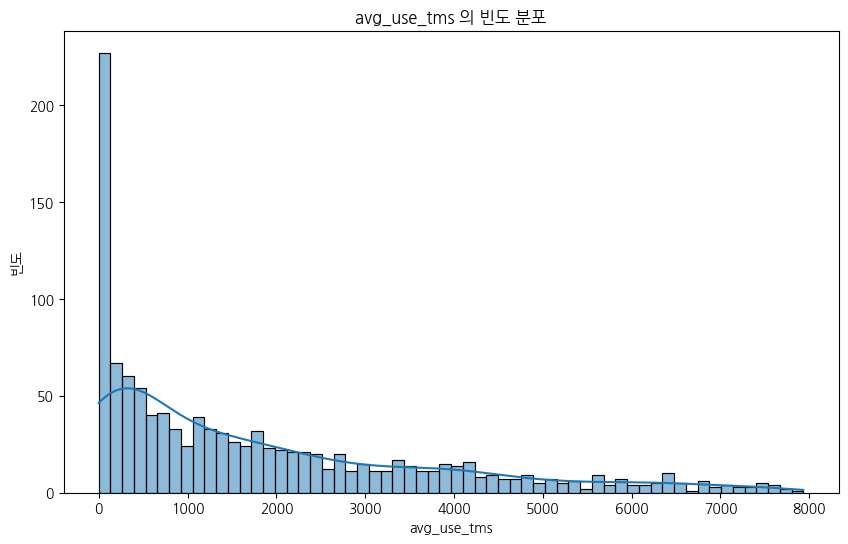

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(vod_tms['avg_use_tms'], bins=60, kde=True)
plt.xlabel('avg_use_tms')
plt.ylabel('빈도')
plt.title('avg_use_tms 의 빈도 분포')
plt.show()

<a id="channel데이터프레임을리뉴얼해보자"></a>
## channel 데이터프레임을 리뉴얼해보자.(channel_df)로 만들었어요 (X)

In [ ]:
vod_df = vod[['series_nm', 'genre', 'genre_detail']]
vod_df = vod_df.drop_duplicates(subset=['series_nm'])
# print(vod_df)

In [ ]:
content_df = content[['series_nm', 'genre', 'genre_detail']]
content_df = content_df.drop_duplicates(subset=['series_nm'])
# print(content_df)

In [ ]:
!pip install fuzzywuzzy

In [ ]:
channel_df=channel

In [ ]:
from fuzzywuzzy import fuzz

for index, row in channel_df.iterrows():
    asset_nm = row['asset_nm']
    similarity_threshold = 50  # 일치성 임계값
    vod_matches = vod_df[vod_df.apply(lambda x: fuzz.token_set_ratio(x['series_nm'], asset_nm) >= similarity_threshold, axis=1)]
    content_matches = content_df[content_df.apply(lambda x: fuzz.token_set_ratio(x['series_nm'], asset_nm) >= similarity_threshold, axis=1)]

    if not vod_matches.empty:
        vod_row = vod_matches.iloc[0]
        channel_df.at[index, 'series_nm'] = vod_row['series_nm']
        channel_df.at[index, 'genre'] = vod_row['genre']
        channel_df.at[index, 'genre_detail'] = vod_row['genre_detail']
    elif not content_matches.empty:
        content_row = content_matches.iloc[0]
        channel_df.at[index, 'series_nm'] = content_row['series_nm']
        channel_df.at[index, 'genre'] = content_row['genre']
        channel_df.at[index, 'genre_detail'] = content_row['genre_detail']

In [ ]:
channel_df.head(30)

In [ ]:
channel_df.to_csv('channel_df.csv')